In [105]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import os 
import matplotlib.pyplot as plt
import numpy as np

## IDEA DEL EXPERIMENTO
+ Modelar el problema como un caso de detección de anomalias usando un autoencoder.
+ Se entreno una red neuronal (Autoencoder) con los datos de continua. La finalidad de esta red es reconstruir la entrada de 153 features teniendo una capa de contracción de 8 neuronas. 
+ Es de esperar que el modelo reconstruya mejor la clase para la cual fue entrenada (continua) y tenga errores de reconstrucción menores que cuando se quiera usar para casos BAJA+1 BAJA+2 (casos anormales) en donde se espere que el error de reconstrucción sea mayor. 


In [59]:
os.chdir( "C:\\Users\\vyago\\Desktop\\Maestría Ciencias de Datos\\07-DMEYF" )

dataset = pd.read_csv("./datasets/competencia2_2022.csv.gz", low_memory=False)


enero = dataset.loc[dataset["foto_mes"]==202101]
marzo = dataset.loc[dataset["foto_mes"]==202103]


In [60]:
enero=enero.fillna(0) # RELLENO CON 0 LOS NULOS, LO NECESITA LA RED
marzo = marzo.fillna(0)

In [63]:
marzo["clase_binaria"] = marzo["clase_ternaria"].apply(lambda x: 1 if x=="CONTINUA" else 0) #CLASE COMBINADA
enero["clase_binaria"] = enero["clase_ternaria"].apply(lambda x: 1 if x=="CONTINUA" else 0)
drop = ["clase_binaria","clase_ternaria","foto_mes","numero_de_cliente"]
X_train = enero[enero.columns.drop( drop)]
y_train = enero["clase_binaria"]
X_test = marzo[marzo.columns.drop(drop)]
y_test = marzo["clase_binaria"]


In [64]:
# ESCALADO DE FEATURES
train_max = X_train.max()
train_min = X_train.min()


train_data = (X_train - train_min)/(train_max - train_min)
test_data = (X_test - train_min)/(train_max - train_min)


In [65]:
train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [66]:
train_labels = y_train.values.astype(bool)
test_labels = y_test.values.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

In [67]:
normal_train_data.shape

TensorShape([159828, 152])

## Modelo

In [68]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(64,activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(64,activation="relu"),
      layers.Dense(152, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [69]:
autoencoder.compile(optimizer='adam', loss='mae')

In [71]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=300, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/300
313/313 [==============================] - 1s 3ms/step - loss: 0.0131 - val_loss: 0.0131
Epoch 2/300
313/313 [==============================] - 1s 3ms/step - loss: 0.0129 - val_loss: 0.0129
Epoch 3/300
313/313 [==============================] - 1s 3ms/step - loss: 0.0128 - val_loss: 0.0128
Epoch 4/300
313/313 [==============================] - 1s 3ms/step - loss: 0.0126 - val_loss: 0.0125
Epoch 5/300
313/313 [==============================] - 1s 4ms/step - loss: 0.0123 - val_loss: 0.0123
Epoch 6/300
313/313 [==============================] - 1s 3ms/step - loss: 0.0122 - val_loss: 0.0122
Epoch 7/300
313/313 [==============================] - 1s 3ms/step - loss: 0.0121 - val_loss: 0.0122
Epoch 8/300
313/313 [==============================] - 1s 3ms/step - loss: 0.0121 - val_loss: 0.0121
Epoch 9/300
313/313 [==============================] - 1s 3ms/step - loss: 0.0121 - val_loss: 0.0121
Epoch 10/300
313/313 [==============================] - 1s 4ms/step - loss: 0.0120 - val_lo

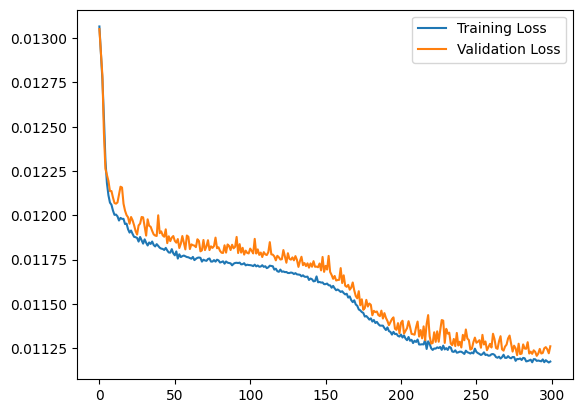

In [72]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

## Perdida de reconstrucción en ENERO (entrenamiento)

4995/4995 [==============================] - 8s 2ms/step


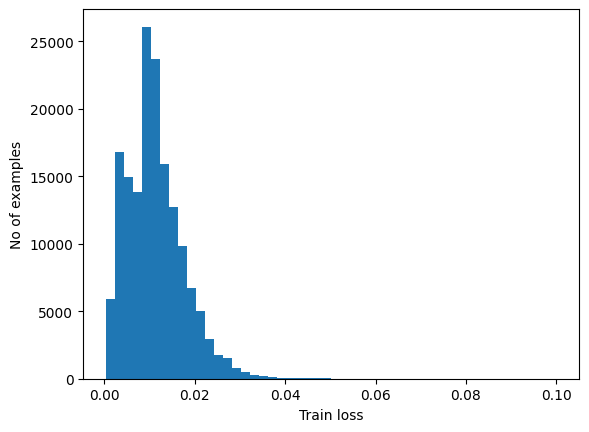

In [73]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

48/48 [==============================] - 0s 938us/step


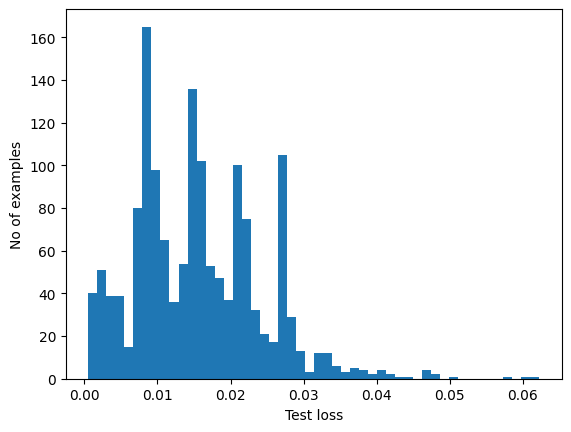

In [98]:
reconstructions = autoencoder.predict(anomalous_train_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_train_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [169]:
def ganancia (normal,anormal):
    gan = 78000*anormal-2000*normal
    return gan



def corte (normal,anormal):
    ganancia_max = -2000000
    thresold = None
    cantidad_envios= None
    for c in np.arange(0.01,0.08,0.0001):
        cant_normal = np.count_nonzero(normal > c)
        cant_anormal = np.count_nonzero( anormal > c)
        gan = ganancia (cant_normal,cant_anormal)
        if gan >ganancia_max:
            threshold = c
            ganancia_max = gan
            cantidad_envios = cant_normal+cant_anormal
    return threshold,ganancia_max,cantidad_envios

    

In [170]:
anormal = test_loss.numpy()
normal = train_loss.numpy()

c, ganancia, envios = corte(normal,anormal) # en base a entrenamiento saco mi mejor punto de corte que maximiza mi ganancia


In [173]:
envios

12571

## Predicción contra marzo (TEST)

In [188]:
reconstruccion_marzo_continua =  autoencoder.predict(normal_test_data)
marzo_loss_continua =  tf.keras.losses.mae(reconstruccion_marzo_continua, normal_test_data)

5029/5029 [==============================] - 8s 2ms/step


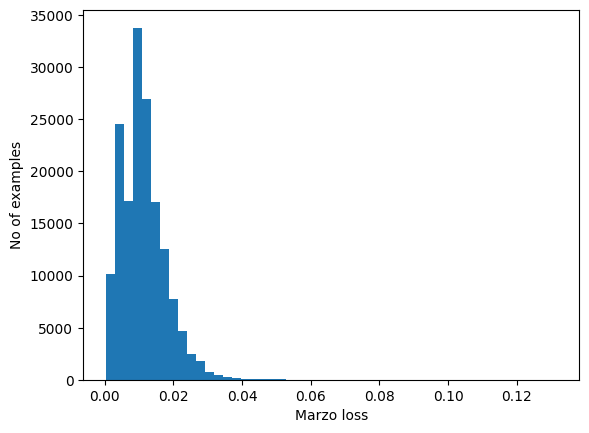

In [189]:
plt.hist(marzo_loss_continua[None, :], bins=50)
plt.xlabel("Marzo loss casos continua")
plt.ylabel("No of examples")
plt.show()

In [190]:
reconstruccion_marzo_abandona =  autoencoder.predict(anomalous_test_data)
marzo_loss_abandona =  tf.keras.losses.mae(reconstruccion_marzo_abandona, anomalous_test_data)

62/62 [==============================] - 0s 2ms/step


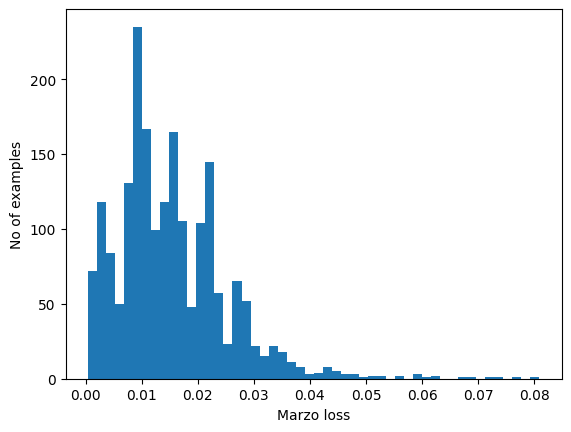

In [191]:
plt.hist(marzo_loss_abandona[None, :], bins=50)
plt.xlabel("Marzo loss casos BAJA+2 BAJA+1")
plt.ylabel("No of examples")
plt.show()

In [192]:
#CALCULO DE GANANCIA PARA MARZO USANDO PUNTO DE CORTE OBTENIDO EN ENERO
marzo_loss_abandona = marzo_loss_abandona.numpy()
marzo_loss_continua = marzo_loss_continua.numpy()



'\ncantidad_continua = np.count_nonzero(marzo_loss_continua > c)\ncantidad_abandona = np.count_nonzero(marzo_loss_abandona > c)\n\nganancia_marzo = ganancia (normal=cantidad_continua,anormal=cantidad_abandona)\nganancia_marzo'

In [193]:
cantidad_continua = np.count_nonzero(marzo_loss_continua > c)
cantidad_abandona = np.count_nonzero(marzo_loss_abandona > c)

In [194]:
cantidad_continua # cantidad de clientes que estimularia y hubieran continuado

12675

In [195]:
cantidad_abandona #cantidad de clientes que estimularia y se hubieran ido (sumando baja+1 y baja+2)

547

In [197]:
78000*cantidad_abandona-2000*cantidad_continua

17316000

## CONCLUSIÓN 

El modelo es exitoso y arroja ganancias positivas en la clasificación de clientes, se puede distinguir claramente dos distribuciones totalmente diferentes en los errores de reconstrucción en ambas clases. Pero como contraposición, no alcanza los valores de ganancias que ofrecen los algoritmos de boosting.